In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modeling 
from sklearn.ensemble import RandomForestRegressor
# Model Performance and Cross Validating & Hyper Parameters Tuning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

import warnings; warnings.simplefilter('ignore')

In [69]:
data = pd.read_csv('data/taskrabbitdata.csv')

In [70]:
# Boolean Masks
#category masks
fa_mask = data.category == 'Furniture Assembly'
mh_mask = data.category == 'Moving Help'
mo_mask = data.category == 'Mounting'
# splitting dataset by category
fa_data = data[fa_mask]
mo_data = data[mo_mask]
mh_data = data[mh_mask]

In [71]:
def make_tasker_df(data):
    
    #grouping by tasker, creating series object and converting them to pandas df
    # total times tasker was hired
    hired = data.groupby('tasker_id')['hired'].sum()
    # how many times tasker appeared on recommendation
    rec_appeared = data.groupby('tasker_id')['recommendation_id'].count()
    # making hire_rate metric column
    hire_rate = (hired/rec_appeared).to_frame()
    # decided to do max because this number is being updated overtime
    tasks_count = data.groupby('tasker_id')['num_completed_tasks'].max().to_frame()
    mean_hourly_rate = data.groupby('tasker_id')['hourly_rate'].mean().to_frame()
    # merging into tasker df
    tasker_df = pd.merge(hire_rate, tasks_count, how = 'right',on='tasker_id')
    tasker_df = pd.merge(tasker_df, mean_hourly_rate, how = 'right', on = 'tasker_id')
    tasker_df.columns = ['hire_rate', 'tasks_to_date', 'mean_hourly_rate']
    return tasker_df


def suggested_rate(tasker_df, data, category = 'fa'):
    
    #tasker status
    tasks = tasker_df.tasks_to_date
    new_tasker = tasks == 0
    tasker = (tasks > 0) & (tasks < 150)
    pro_tasker = (tasks >= 150) & (tasks <350)
    super_pro_tasker = tasks >= 350
    #hired mask
    hired_mask = data.hired == 1
    # category masks
    fa_mask = data.category == 'Furniture Assembly'
    mh_mask = data.category == 'Moving Help'
    mo_mask = data.category == 'Mounting'

    if category == 'fa':
        # Furniture Assembly Hourly Rate Distribution Percentiles
        fa_75 = np.percentile(data[hired_mask][fa_mask].hourly_rate, 75)  
        med_hr_fa = data[hired_mask][fa_mask].hourly_rate.median()
        fa_25 = np.percentile(data[hired_mask][fa_mask].hourly_rate, 25)
        min_hr_fa = data[hired_mask][fa_mask].hourly_rate.min()
        #calculating suggested rate
        tasker_df['suggested_rate'] = np.where(tasks > 350, fa_75,0)
        tasker_df['suggested_rate'] = np.where((tasks >= 150) & (tasks <350), med_hr_fa, tasker_df['suggested_rate'])
        tasker_df['suggested_rate'] = np.where((tasks > 0) & (tasks < 150), fa_25, tasker_df['suggested_rate'])
        tasker_df['suggested_rate'] = np.where(tasks == 0, min_hr_fa, tasker_df['suggested_rate'])
        tasker_df['suggested_rate'] = np.where(tasker_df.hire_rate > 0.2, tasker_df.mean_hourly_rate,tasker_df['suggested_rate'])
        return tasker_df
    if category == 'mo':
        # Mounting Hourly Rate Distribution Percentiles
        min_hr_mo = data[hired_mask][mo_mask].hourly_rate.min()
        med_hr_mo = data[hired_mask][mo_mask].hourly_rate.median()
        mo_75 = np.percentile(data[hired_mask][mo_mask].hourly_rate, 75)  
        mo_25 = np.percentile(data[hired_mask][mo_mask].hourly_rate, 25)
        #calculating suggested rate
        tasker_df['suggested_rate'] = np.where(tasks > 350, mo_75,0)
        tasker_df['suggested_rate'] = np.where((tasks >= 150) & (tasks <350), med_hr_mo, tasker_df['suggested_rate'])
        tasker_df['suggested_rate'] = np.where((tasks > 0) & (tasks < 150), mo_25, tasker_df['suggested_rate'])
        tasker_df['suggested_rate'] = np.where(tasks == 0, min_hr_mo, tasker_df['suggested_rate'])
        tasker_df['suggested_rate'] = np.where(tasker_df.hire_rate > 0.2, tasker_df.mean_hourly_rate,tasker_df['suggested_rate'])
        return tasker_df
    if category =='mh':
        # Moving Help Rate Distribution Percentiles
        min_hr_mh = data[hired_mask][mh_mask].hourly_rate.min()
        med_hr_mh = data[hired_mask][mh_mask].hourly_rate.median()
        mh_75 = np.percentile(data[hired_mask][mh_mask].hourly_rate, 75)  
        mh_25 = np.percentile(data[hired_mask][mh_mask].hourly_rate, 25)
        #calculating suggested rate
        tasker_df['suggested_rate'] = np.where(tasks > 350, mh_75,0)
        tasker_df['suggested_rate'] = np.where((tasks >= 150) & (tasks <350), med_hr_mh, tasker_df['suggested_rate'])
        tasker_df['suggested_rate'] = np.where((tasks > 0) & (tasks < 150), mh_25, tasker_df['suggested_rate'])
        tasker_df['suggested_rate'] = np.where(tasks == 0, min_hr_mh, tasker_df['suggested_rate'])
        tasker_df['suggested_rate'] = np.where(tasker_df.hire_rate > 0.2, tasker_df.mean_hourly_rate,tasker_df['suggested_rate'])
        return tasker_df
 

In [72]:
fa_tasker = make_tasker_df(fa_data)
fa_tasker.head(5)

,hire_rate,tasks_to_date,mean_hourly_rate
tasker_id,,,
1006702141,0.000000,1,27.000000
1006712342,0.000000,2,27.333333
1006720321,0.111111,2,27.000000
1006720473,0.000000,0,29.000000
1006751673,0.000000,6,30.000000


In [113]:
fa_tasker = suggested_rate(fa_tasker, data, category = 'fa')
fa_tasker[['hire_rate', 'tasks_to_date','suggested_rate']].sample(10)

,hire_rate,tasks_to_date,suggested_rate
tasker_id,,,
1006892359,0.047619,247,38.0
1009264688,0.043478,211,38.0
1010808301,0.000000,80,30.0
1008042586,1.000000,452,65.0
1007996057,0.000000,14,30.0
1011983949,0.000000,0,22.0
1010050423,0.097561,283,38.0
1008008634,0.000000,287,38.0
1009370074,0.000000,23,30.0


Text(0, 0.5, 'hourly_rate')

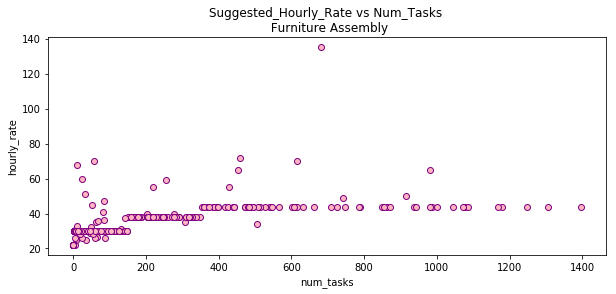

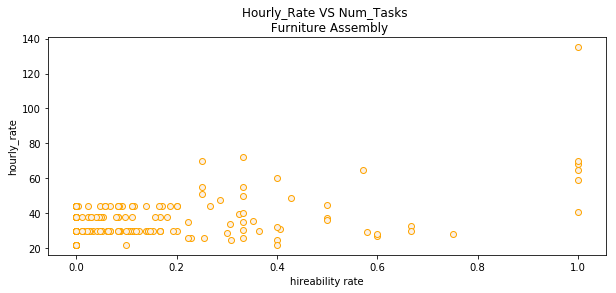

In [108]:
plt.figure(figsize = (10, 4))
plt.title('Suggested_Hourly_Rate vs Num_Tasks \n Furniture Assembly')
plt.scatter(x = fa_tasker.tasks_to_date,
            y = fa_tasker.suggested_rate, 
            alpha=1, color = 'lightpink', 
            edgecolor = 'purple', linewidth = 1)
plt.xlabel('num_tasks')
plt.ylabel('hourly_rate')

plt.figure(figsize = (10, 4))
plt.title('Hourly_Rate VS Num_Tasks \n Furniture Assembly')
plt.scatter(x = fa_tasker.hire_rate,
            y = fa_tasker.suggested_rate, 
            alpha=1, color = 'linen', 
            edgecolor = 'orange', linewidth = 1)
plt.xlabel('hireability rate')
plt.ylabel('hourly_rate')

### Preparing Data for Modeling
                

In [16]:
fa_tasker.columns

Index(['hire_rate', 'tasks_to_date', 'mean_hourly_rate', 'suggested_rate'], dtype='object')

In [21]:
X = fa_tasker[['hire_rate', 'tasks_to_date']].values
y = fa_tasker['suggested_rate'].values
X.shape, y.shape, type(X), type(y)

((514, 2), (514,), numpy.ndarray, numpy.ndarray)

### Creating Training and Test set for cross validation

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Choosing to go with **Random Forest Regression Model** because no linear relationships observed. 

In [56]:
fa_model = RandomForestRegressor(max_depth=8, random_state=0, 
                                 n_estimators=12, max_features = 'log2', min_samples_split = 14).fit(X_train, y_train)
y_pred = fa_model.predict(X_test)

In [57]:
scores = cross_val_score(fa_model, X, y, cv=10, scoring='neg_mean_absolute_error')
scores

array([-1.64848734, -3.0671261 , -1.79185561, -1.59067956, -0.61916716,
       -0.3187598 , -0.60664189, -0.79695657, -0.48670315, -0.65513251])

In [81]:
print('Mean Absolute Error: ', round(mean_absolute_error(y_test, y_pred),4))
print ("R2 Score: ", round(r2_score(y_test,y_pred),4))

Mean Absolute Error:  0.5476
R2 Score:  0.8556


To suggest hourly rate model needs two input numbers:
* hire_rate from last month;
* number of completed tasks to date

For example:

In [100]:
suggested_hourly_rate = fa_model.predict([[0.1, 350]])
print('Suggested Hourly Rate: ', round(y_pred[0], 2))

Suggested Hourly Rate:  31.67


In [127]:
def model(tasker_df, to_predict):
    '''
    INPUT: Tasker df, pandas object;
           to_predict: LIST of two values (orlist of lists of pair values)
    
    OUTPUT: prints MAE, R2, prediction on input
    '''
    X = tasker_df[['hire_rate', 'tasks_to_date']].values
    y = tasker_df['suggested_rate'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    model = RandomForestRegressor(max_depth=8, random_state=0, 
                                 n_estimators=12, max_features = 'log2', min_samples_split = 14).fit(X_train, y_train)
    y_pred = fa_model.predict(X_test)
    suggested_rate = model.predict(to_predict)
    print('Mean Absolute Error: ', round(mean_absolute_error(y_test, y_pred),4))
    print ("R2 Score: ", round(r2_score(y_test,y_pred),4))
    print('Suggested Rate is: ', round(suggested_rate[0],2))
    
    

In [128]:
fa = model(fa_tasker, [[0.3, 500]])

Mean Absolute Error:  0.5476
R2 Score:  0.8556
Suggested Rate is:  48.6


### Same with Mounting Category: 

In [125]:
mo_tasker = make_tasker_df(mo_data)
mo_tasker = suggested_rate(mo_tasker, data, category = 'mo')
mo_tasker.head(3)

,hire_rate,tasks_to_date,mean_hourly_rate,suggested_rate
tasker_id,,,,
1006712342,0.0,2,26.5625,43.0
1006720321,0.0,2,34.0000,43.0
1006720473,0.0,0,38.0000,26.0


Text(0, 0.5, 'hourly_rate')

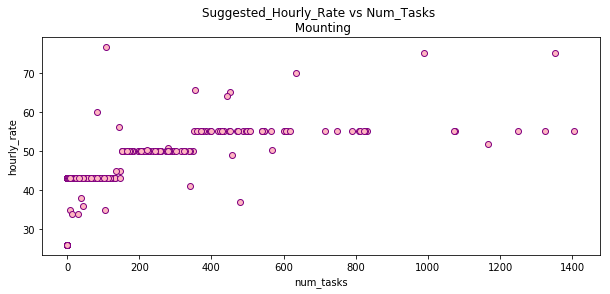

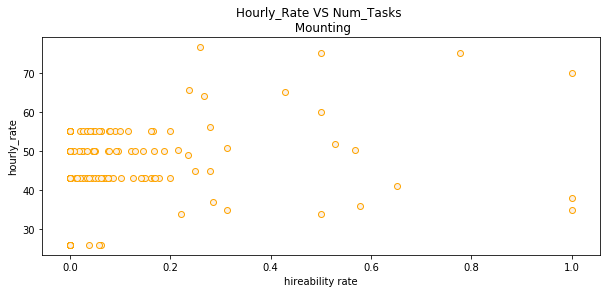

In [126]:
plt.figure(figsize = (10, 4))
plt.title('Suggested_Hourly_Rate vs Num_Tasks \n Mounting')
plt.scatter(x = mo_tasker.tasks_to_date,
            y = mo_tasker.suggested_rate, 
            alpha=1, color = 'lightpink', 
            edgecolor = 'purple', linewidth = 1)
plt.xlabel('num_tasks')
plt.ylabel('hourly_rate')

plt.figure(figsize = (10, 4))
plt.title('Hourly_Rate VS Num_Tasks \n Mounting')
plt.scatter(x = mo_tasker.hire_rate,
            y = mo_tasker.suggested_rate, 
            alpha=1, color = 'linen', 
            edgecolor = 'orange', linewidth = 1)
plt.xlabel('hireability rate')
plt.ylabel('hourly_rate')

In [136]:
mo = model(mo_tasker, [[0.1, 500]])
# not ideal here, need to look at the model further

Mean Absolute Error:  10.5819
R2 Score:  -0.441
Suggested Rate is:  53.92


### Moving Help

In [137]:
mh_tasker = make_tasker_df(mh_data)
mh_tasker = suggested_rate(mh_tasker, data, category = 'mo')
mh_tasker.head(3)

,hire_rate,tasks_to_date,mean_hourly_rate,suggested_rate
tasker_id,,,,
1006646767,0.000000,255,24.000000,50.0
1006648538,0.040404,63,95.858586,43.0
1006655883,0.000000,210,75.000000,50.0


Text(0, 0.5, 'hourly_rate')

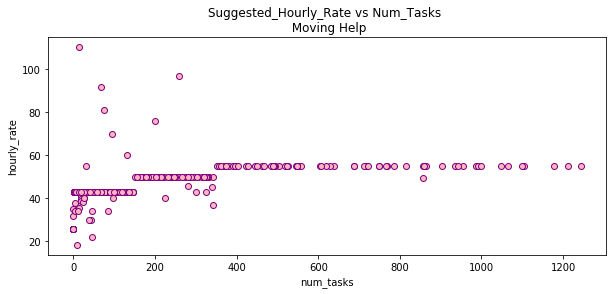

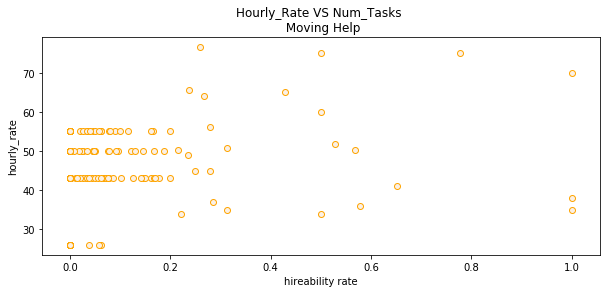

In [138]:
plt.figure(figsize = (10, 4))
plt.title('Suggested_Hourly_Rate vs Num_Tasks \n Moving Help')
plt.scatter(x = mh_tasker.tasks_to_date,
            y = mh_tasker.suggested_rate, 
            alpha=1, color = 'lightpink', 
            edgecolor = 'purple', linewidth = 1)
plt.xlabel('num_tasks')
plt.ylabel('hourly_rate')

plt.figure(figsize = (10, 4))
plt.title('Hourly_Rate VS Num_Tasks \n Moving Help')
plt.scatter(x = mo_tasker.hire_rate,
            y = mo_tasker.suggested_rate, 
            alpha=1, color = 'linen', 
            edgecolor = 'orange', linewidth = 1)
plt.xlabel('hireability rate')
plt.ylabel('hourly_rate')

In [139]:
mh = model(mh_tasker, [[0.3, 350]])

Mean Absolute Error:  12.3892
R2 Score:  -0.6267
Suggested Rate is:  43.93


#### Tuning Hyperparameters

In [54]:
def Grid_Search_CV_RFR(X_train, y_train):
  

    estimator = RandomForestRegressor()
    param_grid = { 
            "n_estimators"      : [10,12, 14,16,20,50],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [12,14,16,18, 20, 40, 60],
            "bootstrap": [True, False],
            "max_depth"         : [2,4,6,8,10,16]
            }

    grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

    grid.fit(X_train, y_train)

    return grid.best_score_ , grid.best_params_
Grid_Search_CV_RFR(X_train, y_train)

(0.7642035263074989,
 {'bootstrap': True,
  'max_depth': 8,
  'max_features': 'log2',
  'min_samples_split': 14,
  'n_estimators': 12})